In [47]:
!pip install fredapi
!pip install statsmodels

In [48]:
from fredapi import Fred
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import logging

In [49]:
# Initialize FRED with API key
fred = Fred(api_key='ab1902d0639c8120e9672343d702e423')

In [50]:
# Define the time range
start_date = '2004-01-01'
end_date = '2024-01-01'

In [51]:
# Fetch data from FRED on a monthly basis
home_price_index = fred.get_series('CSUSHPISA', observation_start=start_date, observation_end=end_date)
interest_rates = fred.get_series('FEDFUNDS', observation_start=start_date, observation_end=end_date)
unemployment_rate = fred.get_series('UNRATE', observation_start=start_date, observation_end=end_date)
cpi = fred.get_series('CPIAUCSL', observation_start=start_date, observation_end=end_date)
gdp_growth = fred.get_series('A191RL1Q225SBEA', observation_start=start_date, observation_end=end_date)
population_growth = fred.get_series('POPTHM', observation_start=start_date, observation_end=end_date)
median_income = fred.get_series('MEHOINUSA672N', observation_start=start_date, observation_end=end_date)
consumer_confidence = fred.get_series('UMCSENT', observation_start=start_date, observation_end=end_date)


In [52]:
# Combine all data
data = pd.DataFrame({
    'Home_Price_Index': home_price_index,
    'Interest_Rates': interest_rates,
    'Unemployment_Rate': unemployment_rate,
    'CPI': cpi,
    'GDP_Growth': gdp_growth,
    'Population_Growth': population_growth,
    'Median_Income': median_income,
    'Consumer_Confidence': consumer_confidence
})


In [53]:
data

,Home_Price_Index,Interest_Rates,Unemployment_Rate,CPI,GDP_Growth,Population_Growth,Median_Income,Consumer_Confidence
2004-01-01,141.647,1.00,5.7,186.300,2.3,292046.0,65760.0,103.8
2004-02-01,143.192,1.01,5.6,186.700,NaN,292230.0,NaN,94.4
2004-03-01,145.058,1.00,5.8,187.100,NaN,292434.0,NaN,95.8
2004-04-01,146.592,1.00,5.6,187.400,3.1,292651.0,NaN,94.2
2004-05-01,148.186,1.00,5.6,188.200,NaN,292872.0,NaN,90.2
...,...,...,...,...,...,...,...,...
2023-09-01,310.894,5.33,3.8,307.288,NaN,335612.0,NaN,67.8
2023-10-01,312.756,5.33,3.8,307.531,3.4,335773.0,NaN,63.8
2023-11-01,313.632,5.33,3.7,308.024,NaN,335925.0,NaN,61.3
2023-12-01,314.443,5.33,3.7,308.742,NaN,336070.0,NaN,69.7


In [54]:
# Interpolating missing values
data = data.interpolate()

In [55]:
data

,Home_Price_Index,Interest_Rates,Unemployment_Rate,CPI,GDP_Growth,Population_Growth,Median_Income,Consumer_Confidence
2004-01-01,141.647,1.00,5.7,186.300,2.300000,292046.0,65760.0,103.8
2004-02-01,143.192,1.01,5.6,186.700,2.566667,292230.0,65845.0,94.4
2004-03-01,145.058,1.00,5.8,187.100,2.833333,292434.0,65930.0,95.8
2004-04-01,146.592,1.00,5.6,187.400,3.100000,292651.0,66015.0,94.2
2004-05-01,148.186,1.00,5.6,188.200,3.333333,292872.0,66100.0,90.2
...,...,...,...,...,...,...,...,...
2023-09-01,310.894,5.33,3.8,307.288,3.900000,335612.0,74580.0,67.8
2023-10-01,312.756,5.33,3.8,307.531,3.400000,335773.0,74580.0,63.8
2023-11-01,313.632,5.33,3.7,308.024,2.733333,335925.0,74580.0,61.3
2023-12-01,314.443,5.33,3.7,308.742,2.066667,336070.0,74580.0,69.7


In [56]:
# Remove outliers using Z-score
z_scores = np.abs((data - data.mean()) / data.std())
data = data[(z_scores < 3).all(axis=1)]
data

,Home_Price_Index,Interest_Rates,Unemployment_Rate,CPI,GDP_Growth,Population_Growth,Median_Income,Consumer_Confidence
2004-01-01,141.647,1.00,5.7,186.300,2.300000,292046.0,65760.0,103.8
2004-02-01,143.192,1.01,5.6,186.700,2.566667,292230.0,65845.0,94.4
2004-03-01,145.058,1.00,5.8,187.100,2.833333,292434.0,65930.0,95.8
2004-04-01,146.592,1.00,5.6,187.400,3.100000,292651.0,66015.0,94.2
2004-05-01,148.186,1.00,5.6,188.200,3.333333,292872.0,66100.0,90.2
...,...,...,...,...,...,...,...,...
2023-09-01,310.894,5.33,3.8,307.288,3.900000,335612.0,74580.0,67.8
2023-10-01,312.756,5.33,3.8,307.531,3.400000,335773.0,74580.0,63.8
2023-11-01,313.632,5.33,3.7,308.024,2.733333,335925.0,74580.0,61.3
2023-12-01,314.443,5.33,3.7,308.742,2.066667,336070.0,74580.0,69.7


In [57]:
# Summary Statistics
data.describe()

,Home_Price_Index,Interest_Rates,Unemployment_Rate,CPI,GDP_Growth,Population_Growth,Median_Income,Consumer_Confidence
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,189.048864,1.540255,5.801277,235.814830,2.271773,316754.285106,69405.457447,81.274043
std,48.967737,1.800888,1.954121,30.368419,2.436171,13205.148780,4566.597980,13.079545
min,136.531000,0.060000,3.400000,186.300000,-8.500000,292046.000000,63350.000000,50.000000
25%,152.075500,0.120000,4.400000,214.334000,1.433333,305723.500000,65635.000000,71.150000
50%,176.437000,0.410000,5.100000,233.669000,2.466667,317864.000000,67825.000000,82.500000
75%,203.984500,2.400000,7.200000,251.922500,3.450000,329128.000000,74580.000000,93.150000
max,315.728000,5.330000,11.000000,309.685000,14.400000,336194.000000,78250.000000,103.800000


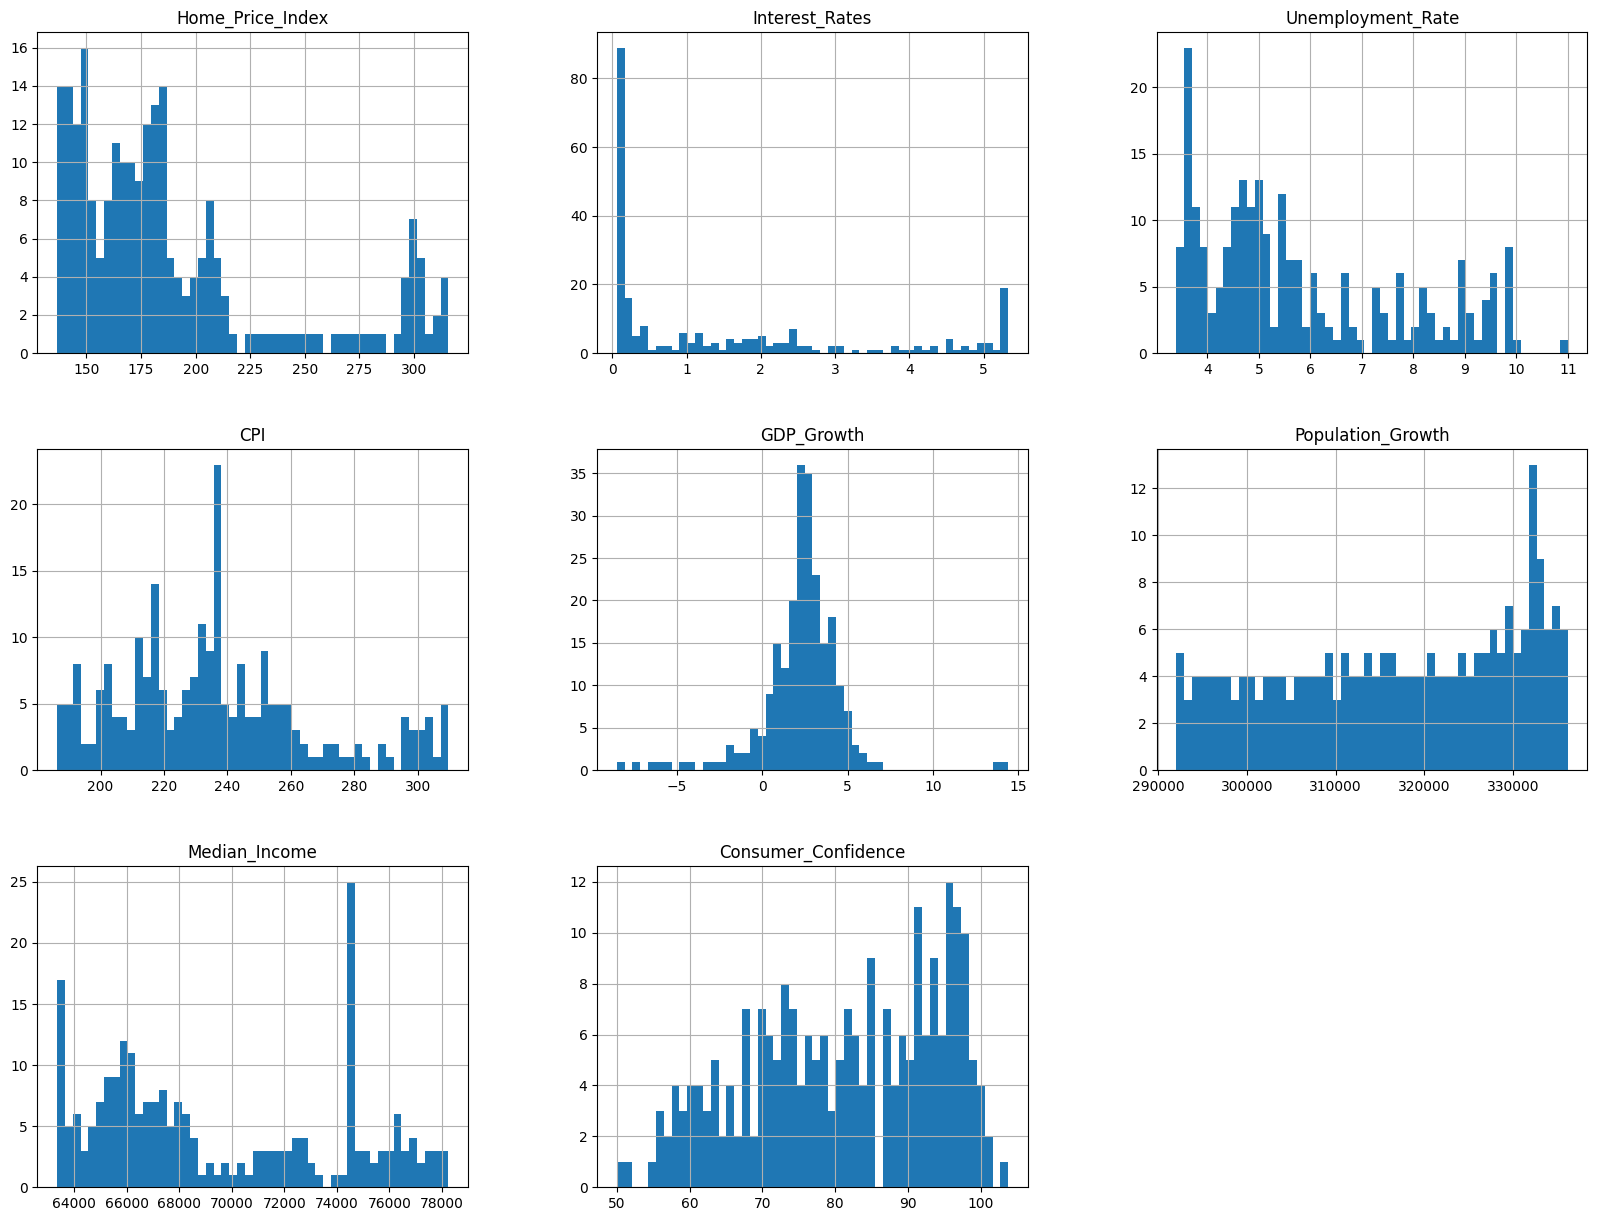

In [58]:
# Distribution of Each Feature
data.hist(bins=50, figsize=(20,15))
plt.show()

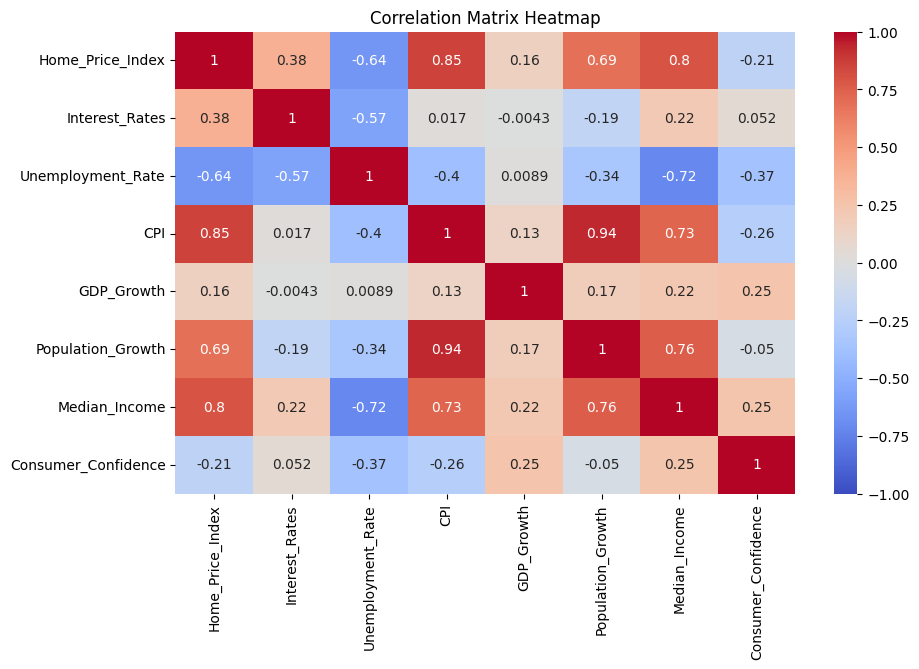

In [59]:
# Correlation Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

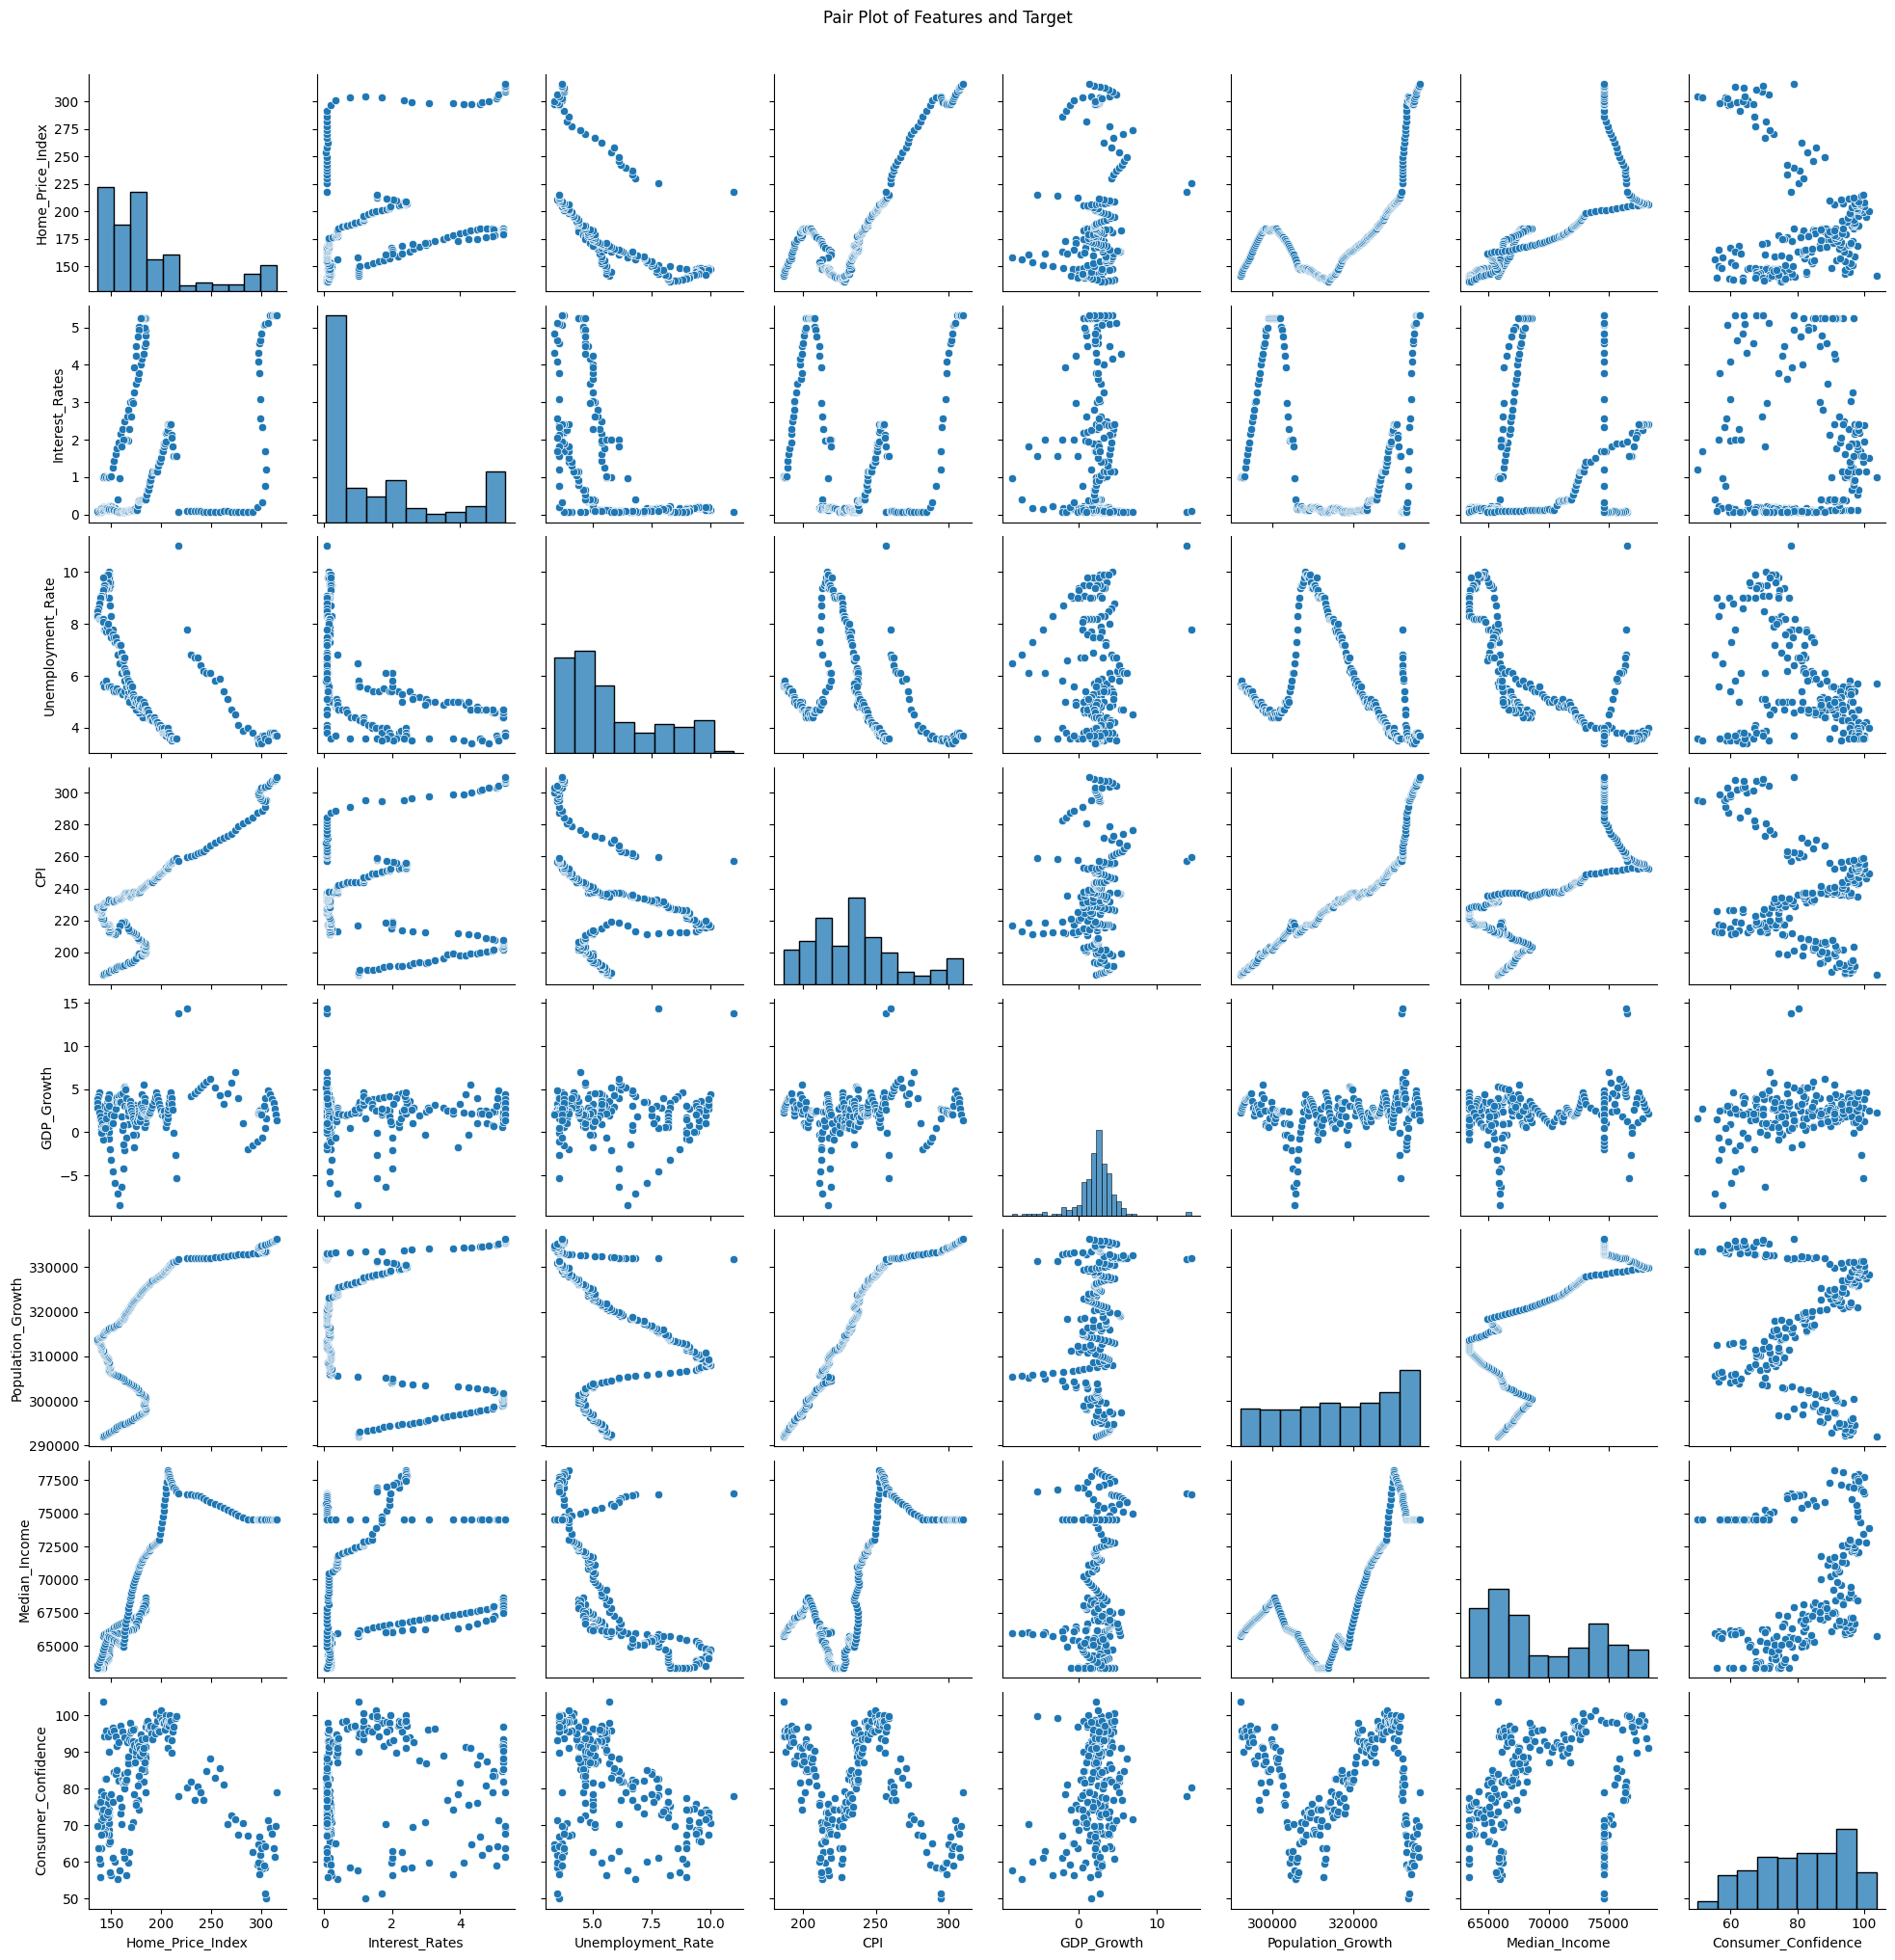

In [60]:
# Pair Plot
sns.pairplot(data)
plt.suptitle('Pair Plot of Features and Target', y=1.02)
plt.show()

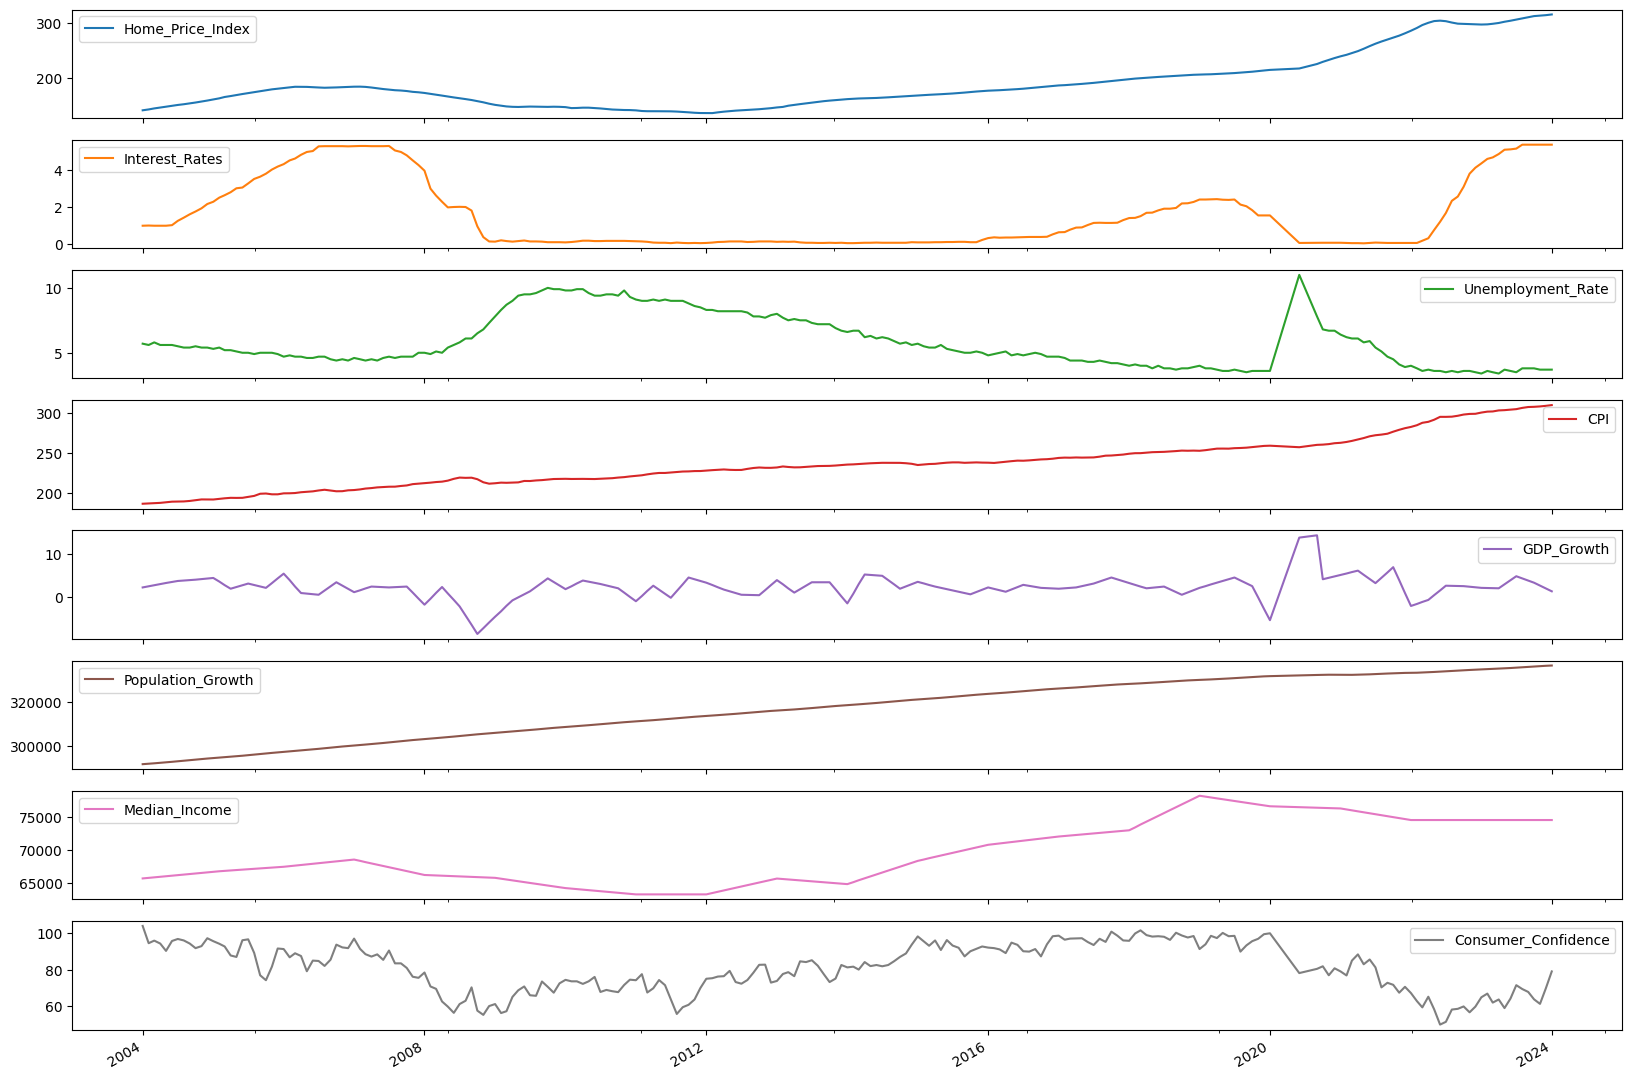

In [61]:
# Time Series Plots
data.plot(subplots=True, figsize=(20, 15))
plt.show()

In [62]:
# Prepare features and target variable
X = data.drop('Home_Price_Index', axis=1)
y = data['Home_Price_Index']


In [63]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

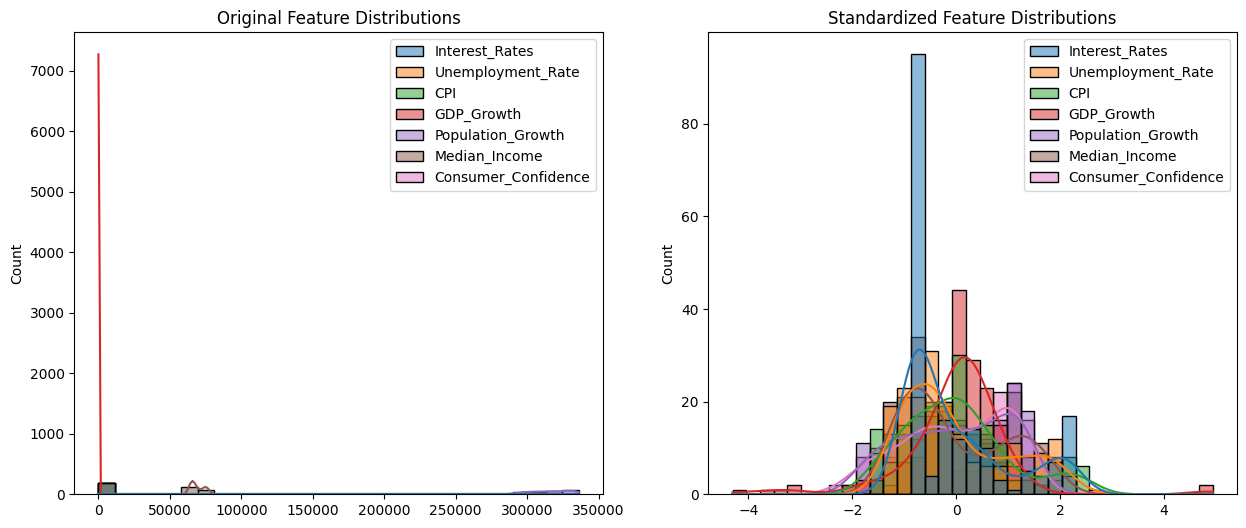

In [65]:
# Feature Distributions Before and After Standardization
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(X_train, ax=axes[0], kde=True)
axes[0].set_title('Original Feature Distributions')
sns.histplot(X_train_scaled, ax=axes[1], kde=True)
axes[1].set_title('Standardized Feature Distributions')
plt.show()

In [66]:
# Hyperparameter tuning for Ridge using GridSearchCV
ridge = Ridge()
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10, 100]},
             scoring='neg_mean_squared_error')

In [67]:
# Best Ridge model
best_ridge = grid_search_ridge.best_estimator_

In [68]:
# Cross-validation scores for Ridge
cross_val_scores_ridge = cross_val_score(best_ridge, X_train_scaled, y_train, cv=5, scoring='r2')
print(f'Ridge Cross-Validation R^2 Scores: {cross_val_scores_ridge}')
print(f'Ridge Mean Cross-Validation R^2 Score: {cross_val_scores_ridge.mean()}')

Ridge Cross-Validation R^2 Scores: [0.97777552 0.94604202 0.93611486 0.97216107 0.96925206]
Ridge Mean Cross-Validation R^2 Score: 0.9602691053198399


In [69]:
# Fit the best Ridge model and predict
best_ridge.fit(X_train_scaled, y_train)
y_pred_ridge = best_ridge.predict(X_test_scaled)

In [70]:
# Evaluation metrics for Ridge
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'Ridge Best alpha: {grid_search_ridge.best_params_["alpha"]}')
print(f'Ridge RMSE: {rmse_ridge}')
print(f'Ridge R-squared: {r2_ridge}')

Ridge Best alpha: 0.01
Ridge RMSE: 8.689284255551142
Ridge R-squared: 0.9730356156612795


In [71]:
# Hyperparameter tuning for Lasso using GridSearchCV
lasso = Lasso()
param_grid_lasso = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10, 100]},
             scoring='neg_mean_squared_error')

In [72]:
# Best Lasso model
best_lasso = grid_search_lasso.best_estimator_

In [73]:
# Cross-validation scores for Lasso
cross_val_scores_lasso = cross_val_score(best_lasso, X_train_scaled, y_train, cv=5, scoring='r2')
print(f'Lasso Cross-Validation R^2 Scores: {cross_val_scores_lasso}')
print(f'Lasso Mean Cross-Validation R^2 Score: {cross_val_scores_lasso.mean()}')


Lasso Cross-Validation R^2 Scores: [0.97794676 0.94632136 0.93632557 0.97195492 0.96906544]
Lasso Mean Cross-Validation R^2 Score: 0.9603228098954005


In [74]:
# Fit the best Lasso model and predict
best_lasso.fit(X_train_scaled, y_train)
y_pred_lasso = best_lasso.predict(X_test_scaled)

In [75]:
# Evaluation metrics for Lasso
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f'Lasso Best alpha: {grid_search_lasso.best_params_["alpha"]}')
print(f'Lasso RMSE: {rmse_lasso}')
print(f'Lasso R-squared: {r2_lasso}')

Lasso Best alpha: 0.01
Lasso RMSE: 8.706990223962862
Lasso R-squared: 0.972925614204709


In [76]:
# Coefficients for Ridge
ridge_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_ridge.coef_
})
print("Ridge Coefficients:")
print(ridge_coefficients)

Ridge Coefficients:
               Feature  Coefficient
0       Interest_Rates    -1.698010
1    Unemployment_Rate    -6.263968
2                  CPI    71.115446
3           GDP_Growth     3.145973
4    Population_Growth   -55.893084
5        Median_Income    24.437607
6  Consumer_Confidence    -3.426272


In [77]:
# Coefficients for Lasso
lasso_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso.coef_
})
print("Lasso Coefficients:")
print(lasso_coefficients)

Lasso Coefficients:
               Feature  Coefficient
0       Interest_Rates    -1.580454
1    Unemployment_Rate    -6.257278
2                  CPI    70.770587
3           GDP_Growth     3.136046
4    Population_Growth   -55.472522
5        Median_Income    24.356269
6  Consumer_Confidence    -3.471552


In [78]:
# Learning Curve for Ridge
train_sizes, train_scores, test_scores = learning_curve(best_ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)


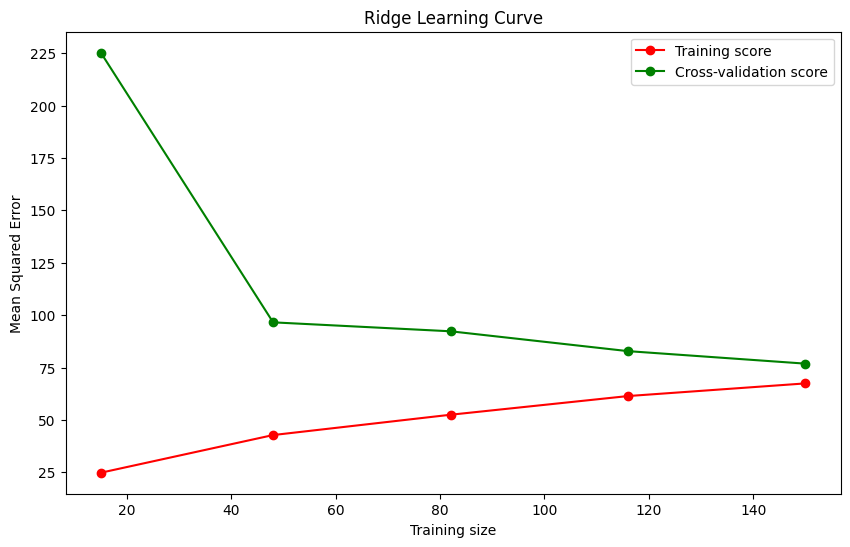

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training size')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Learning Curve')
plt.legend(loc='best')
plt.show()

In [80]:
# Learning Curve for Lasso
train_sizes, train_scores, test_scores = learning_curve(best_lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

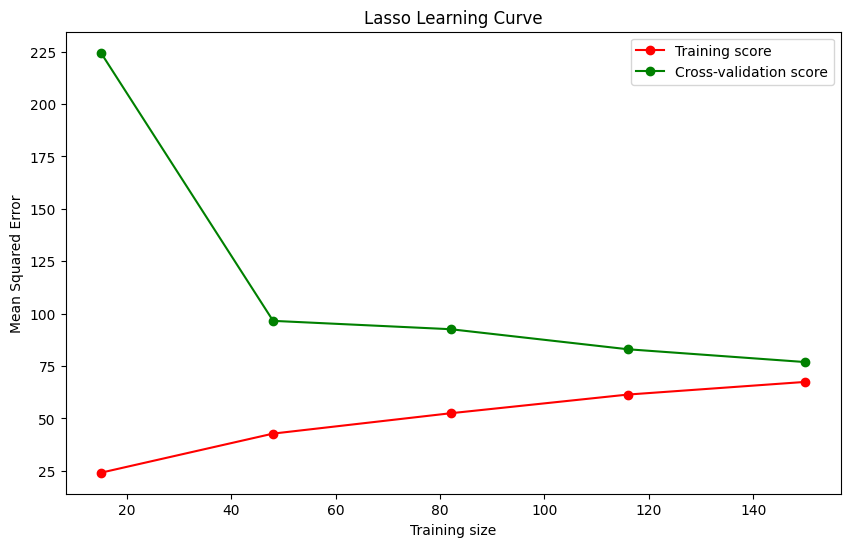

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training size')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Learning Curve')
plt.legend(loc='best')
plt.show()

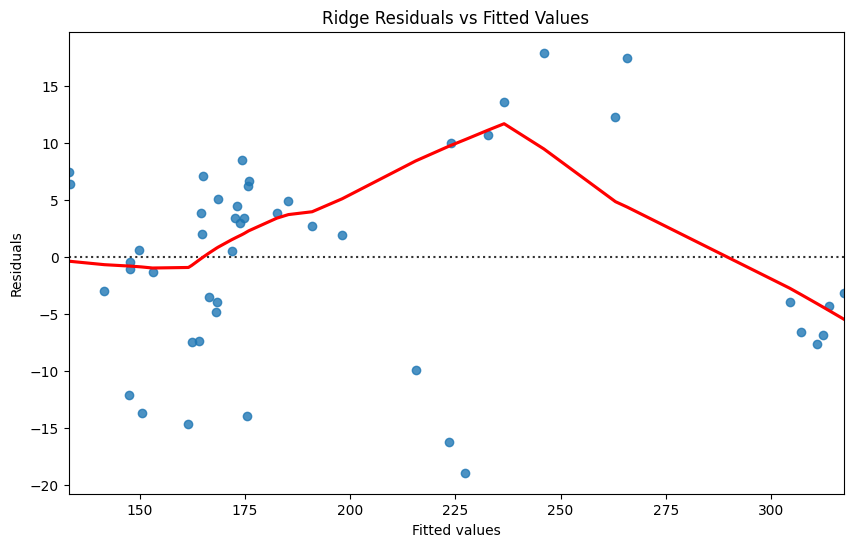

In [82]:
# Residuals vs Fitted Values Plot for Ridge
plt.figure(figsize=(10, 6))
residuals_ridge = y_test - y_pred_ridge
sns.residplot(x=y_pred_ridge, y=residuals_ridge, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Ridge Residuals vs Fitted Values')
plt.show()

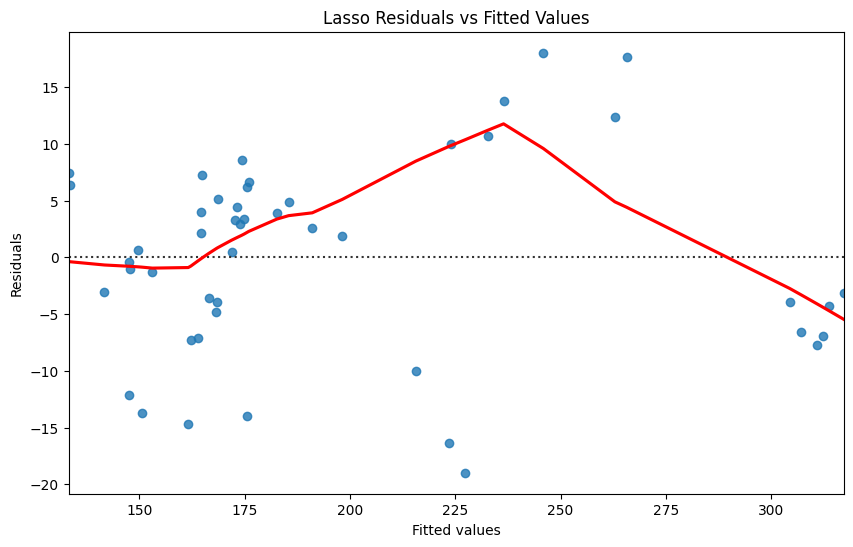

In [83]:
# Residuals vs Fitted Values Plot for Lasso
plt.figure(figsize=(10, 6))
residuals_lasso = y_test - y_pred_lasso
sns.residplot(x=y_pred_lasso, y=residuals_lasso, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Lasso Residuals vs Fitted Values')
plt.show()

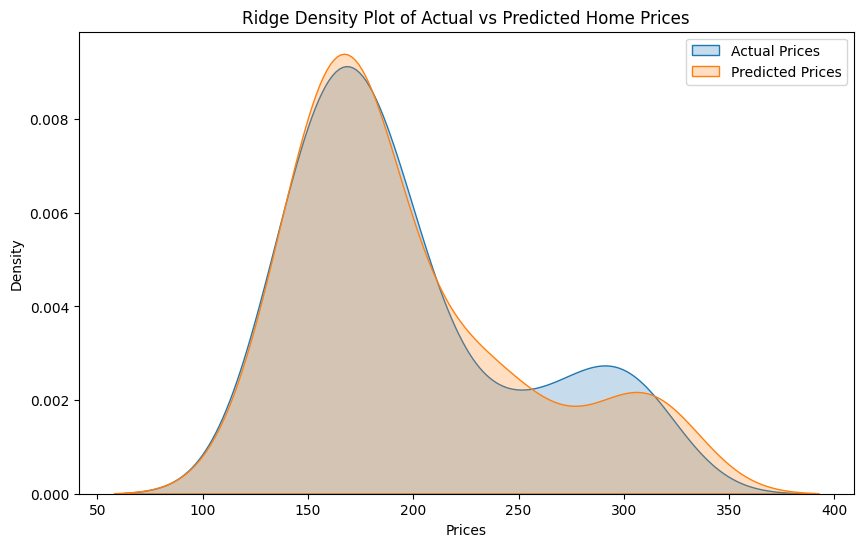

In [84]:
# Density Plot of Actual vs Predicted Home Prices for Ridge
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Prices', fill=True)
sns.kdeplot(y_pred_ridge, label='Predicted Prices', fill=True)
plt.xlabel('Prices')
plt.ylabel('Density')
plt.title('Ridge Density Plot of Actual vs Predicted Home Prices')
plt.legend()
plt.show()

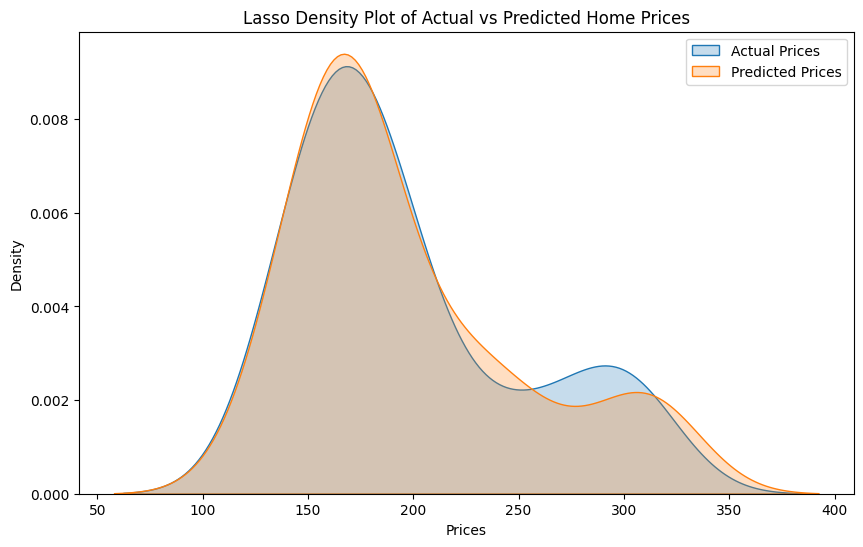

In [85]:
# Density Plot of Actual vs Predicted Home Prices for Lasso
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Prices', fill=True)
sns.kdeplot(y_pred_lasso, label='Predicted Prices', fill=True)
plt.xlabel('Prices')
plt.ylabel('Density')
plt.title('Lasso Density Plot of Actual vs Predicted Home Prices')
plt.legend()
plt.show()

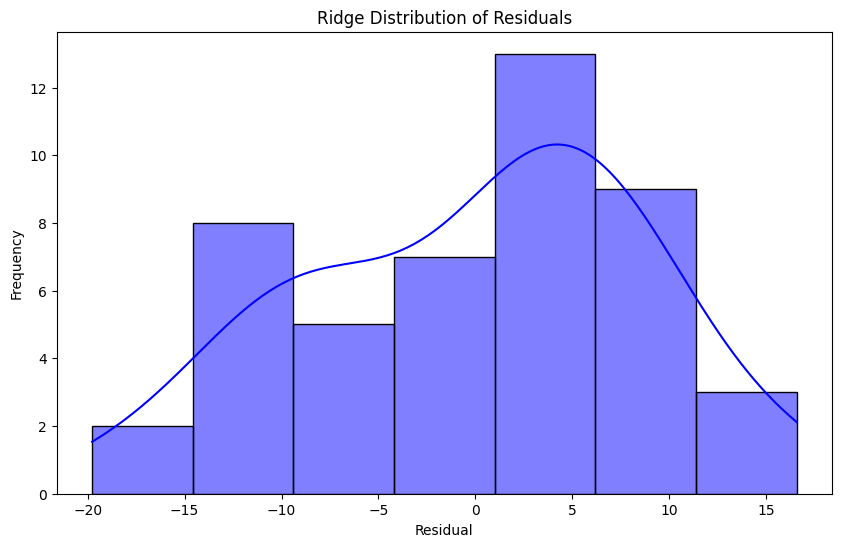

In [86]:
# Residuals plot for Ridge
plt.figure(figsize=(10, 6))
sns.histplot(residuals_ridge, kde=True, color='blue')
plt.title('Ridge Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

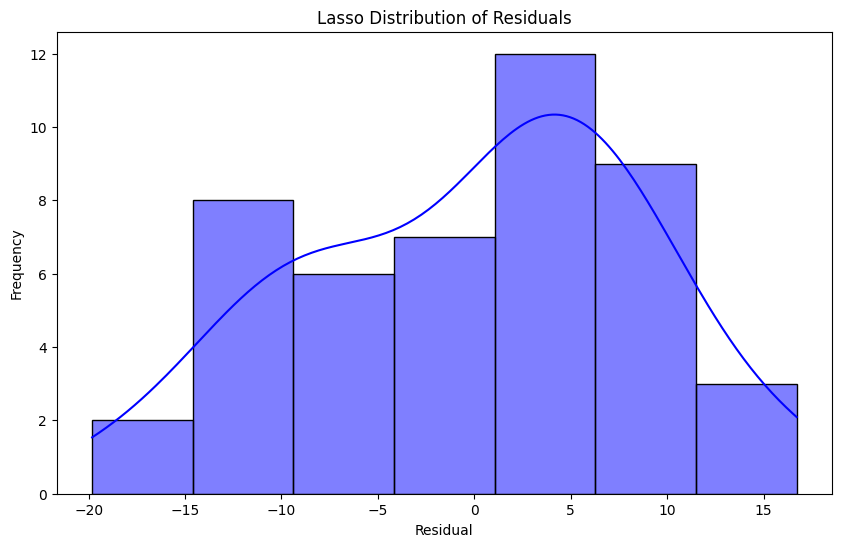

In [87]:
# Residuals plot for Lasso
plt.figure(figsize=(10, 6))
sns.histplot(residuals_lasso, kde=True, color='blue')
plt.title('Lasso Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

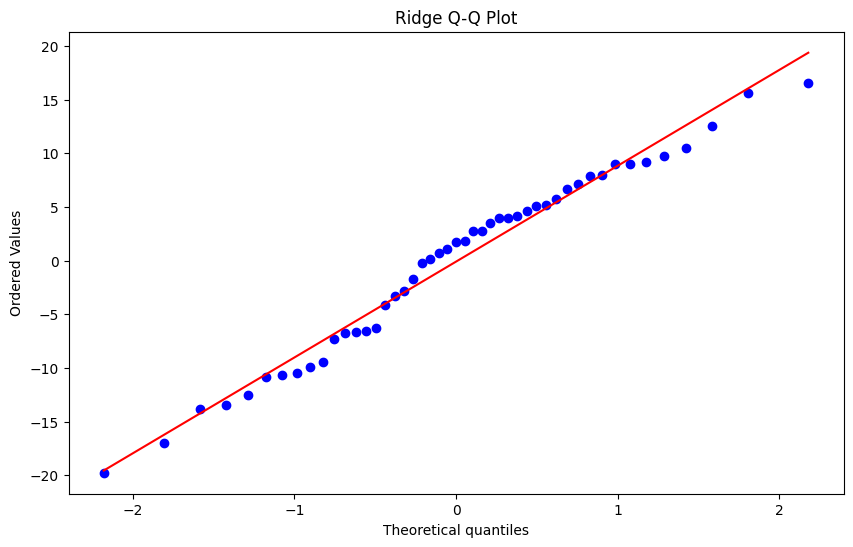

In [88]:
# Q-Q plot for Ridge residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals_ridge, dist="norm", plot=plt)
plt.title('Ridge Q-Q Plot')
plt.show()


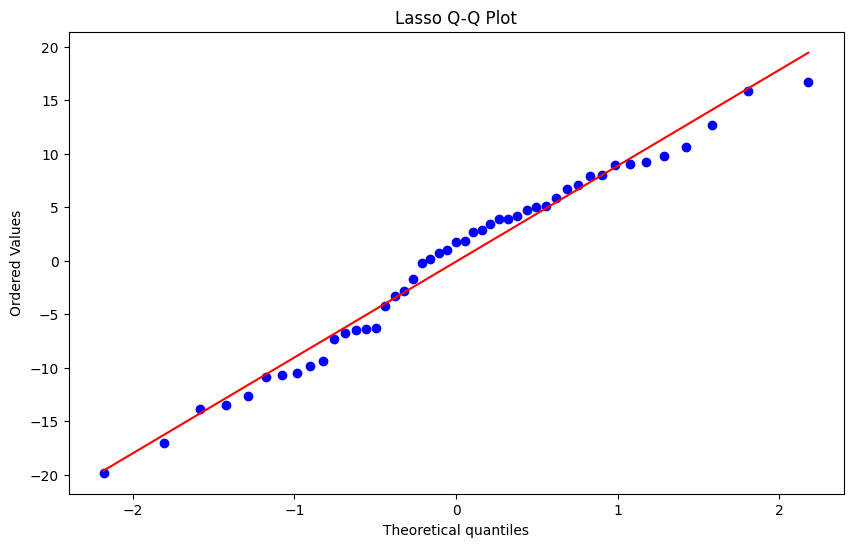

In [89]:
# Q-Q plot for Lasso residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals_lasso, dist="norm", plot=plt)
plt.title('Lasso Q-Q Plot')
plt.show()

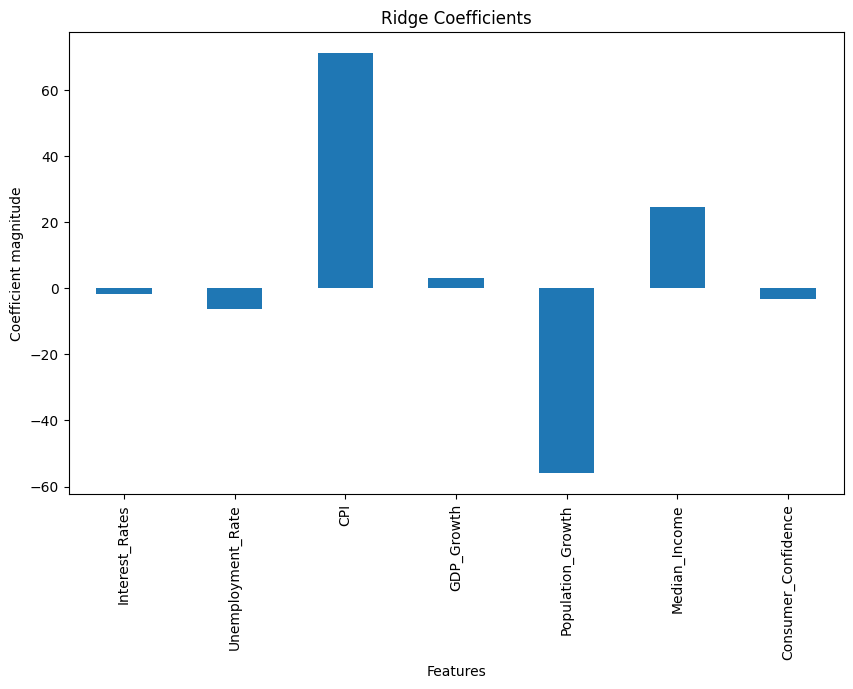

In [90]:
# Coefficients plot for Ridge
plt.figure(figsize=(10, 6))
coefficients_ridge = pd.Series(best_ridge.coef_, index=X.columns)
coefficients_ridge.plot(kind='bar')
plt.title('Ridge Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient magnitude')
plt.show()

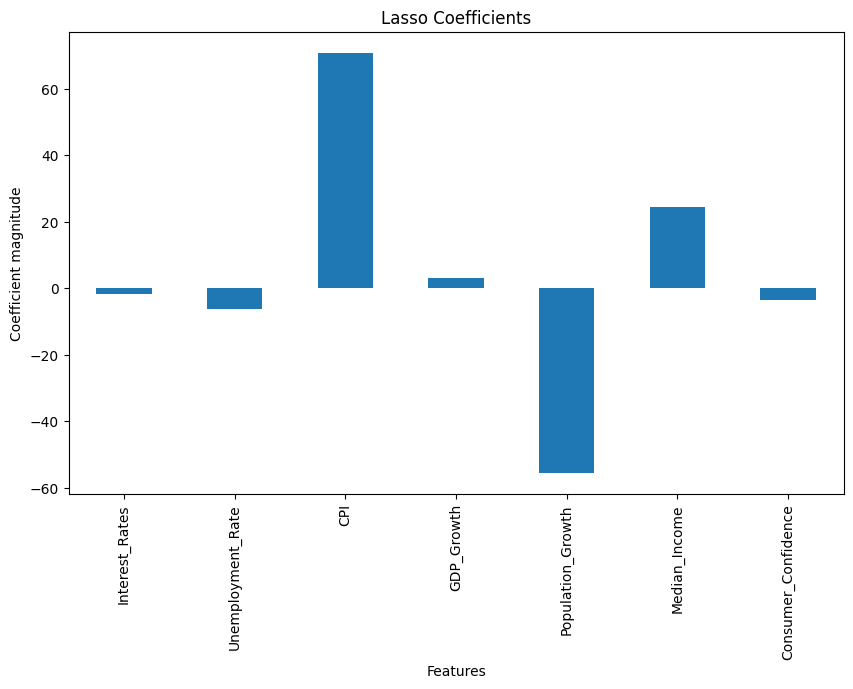

In [91]:
# Coefficients plot for Lasso
plt.figure(figsize=(10, 6))
coefficients_lasso = pd.Series(best_lasso.coef_, index=X.columns)
coefficients_lasso.plot(kind='bar')
plt.title('Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient magnitude')
plt.show()